# Various probabilistic planning methods
Jiří Němeček

This is a report for an assignment concerning comparisons of few planning methods for probabilistic environments. In particular, it compares the methods on a 2D maze environment, with delay (negative reward) tiles and stochastic actions. More details in the enclosed assignment PDF. 

This report constist of 2 parts:
 - Description of implementation details
 - Method comparison
 
## Implementation
My main intention in implementing this environment was to have everything as modular as possible while retaining some logical division of responsibilities of the classes.

First of all, there is `Maze` class that parses a maze based on the file with its definition. It also overloads `__str__` method, and creates a string representation that is useful to show in terminal. Tile types are mapped on color, and we can optionally write some text into the tiles. Start is blue, goal is green, delay fields are red and walls are white.

In [1]:
from maze import Maze
maze = Maze("dataset-assignment2/data/maze-7-A1.txt")
print(maze)

Afterwards I have added a module `utils` with utilities facilitating the navigation in a maze. A class `Pos` serving more like a data type and a class `Dir` that implements tturning logic. They also overload the `__str__` method to enable better viewing in the terminal.

In [2]:
from utils import Dir
print(Dir.NORTH, Dir.EAST, Dir.SOUTH, Dir.WEST)

▲ ► ▼ ◄


Another useful class is the `Engine` class, that contains all game logic, with implementation of the stochastic moves. It also contains deterministic variant of the same actions, that is required for some algorithms, such as FF-replan.

Then, there is a `Strategy` abstract class, that has a single method to be overloaded, called `next_move`. This method is required by various testing functions in `stat_tester` module. It must be implemented by all strategies in order to test them.

### FF - replan
In `ffreplan` module, there is a `FFReplan` class. It inherits from `Strategy` class. In its inilializer, it computes a determinstic path to the goal. Then it can be run, and in case the agent diverges from its path and gets to a tile that is not on the shortest path, the path gets recomputed from the current position to the goal tile. This makes the runtime very slow on bigger mazes.

For computing the shortest path, an A* algorithm with Euclidean distance as a heuristic is used. Each transition has cost equal to $-reward$ in the originally posed problem. 

In [3]:
from engine import Engine
from ffreplan import FFReplan
from stat_tester import simulate_sequence

engine = Engine(maze)
ffreplan = FFReplan(engine)

path, rew, missteps = simulate_sequence(engine, ffreplan)

path_map = [[None]*maze.w for _ in range(maze.h)]
for i, (pos, direction) in enumerate(path):
    path_map[pos.y][pos.x] = str(i%100) + str(direction)
print(f"Path was {len(path)} steps long, Pepa made {sum(missteps)} total missteps ({sum(missteps)/len(path)*100:.2f}%)")
print("Total reward:", sum(rew))
print(maze.to_str(path_map))

Path was 18 steps long, Pepa made 3 total missteps (16.67%)
Total reward: 183
    0▼               
    1► 2► 3► 5► 6▼   
                7▼   
         11▼10◄ 9◄   
         14▼         
         15►16►17▼   
                     



This visulaization of directions and numbers serves the purpose of visualizing the path that the agent took. What is shown is the last time the agent was on the tile and the action it chose at that point. The time has always at most 2 digits (to make the whole thing readable), so it is considered timestep modulo 100.

### Value Iteration
Conversely, in `val_iter` module, there is a `ValueIteration` class, that inherits from the `Strategy` class. Unlike FF-replan, it precomputes its entire policy in the initialization. It takes 2 additional parameters `gamma` and an optional `lim_residual`. `gamma` is the $\gamma$ in the classical sense as we know the algorithm, a kind of discount factor. The `lim_residual` parameter sets the threshold of maximal residual in an iteration. If the maximal residual in one full iteration of value iteration algorithm goes bellow this threshold, we stop the algorithm and compute the policy. That is then stored as a dictionary, making the runtime very fast. The values $1-10^{-5}$ for `gamma` and $10^{-10}$ for `lim_residual` shown the best behavior in my tests. Higher values of `lim_residual` did not lead to a convergence on big mazes. This high values of `gamma` facilitate the propagation of the values through bigger mazes (state-spaces). It takes quite long to compute for big mazes (up to 5 minutes), but the runtime speed overweighs this.

To help the computation, the values are iniliatlized on the ideal value if the actions were deterministic. That is done by performing a dijkstra algorithm from the goal tile. The values are defined only for reachable tiles.

Because we have values of states (~tiles in this case), we can visualize them. Similarly, we can visualize the policy using the direction arrows shown earlier. The values of $V$ are rounded to integers.

In [4]:
from val_iter import ValueIteration

value_iteration = ValueIteration(engine, gamma=0.99999, lim_residual=1e-10)

print("Policy:")
value_iteration.show_policy(engine)

print("Value:")
value_iteration.show_value(engine)

path, rew, missteps = simulate_sequence(engine, value_iteration)

path_map = [[None]*maze.w for _ in range(maze.h)]
for i, (pos, direction) in enumerate(path):
    path_map[pos.y][pos.x] = str(i%100) + str(direction)
print(f"Path was {len(path)} steps long, Pepa made {sum(missteps)} total missteps ({sum(missteps)/len(path)*100:.2f}%)")
print("Total reward:", sum(rew))
print(maze.to_str(path_map))

Policy:
   ▼          
   ► ► ▲ ► ▼  
       ▼   ▼  
   ▼   ▼ ◄ ◄  
   ► ► ▼      
   ► ► ► ► ▼  
           ▲  

Value:
   172               
   174175177185186   
         191   188   
   190   193191189   
   192193194         
   193194196198199   
                0    

Path was 43 steps long, Pepa made 16 total missteps (37.21%)
Total reward: 158
    3▼               
    4►21►23▲30►31▼   
               32▼   
         35▼34◄33◄   
         36▼         
         37►41►42▼   
                     



Interesting thing to note is the policy decision of the agent to go north on the tile above the delay tile. This, in my testing  (presented later) showed almost one point better on avarage than the straight strategy of the FF-replan algorithm. The result is not however statistically relevant, even though the standard deviation of the reward of ValueIteration approach is significantly twice as low.

## Evaluation 
For evlauation, as mentioned before, there are a couple methods in the `stat_tester` module. Using those in the way presented in `main.py`, I have precomputed runs for as many iterations as was reasonable, given some time frame. They are stored in the results folder, and here I will go through them, showing some plots and stating some conclusions. There are 

In [5]:
# loading the data
import pickle

ALGOS = ["ff_replan", "val_iter"]
SIZES = ["7", "15", "25", "51", "101"]
TYPES = ["A1", "A2", "B", "C", "E"]

rewards = {}
times = {}
tot_times = {}
for a in ALGOS:
    rewards[a] = {}
    times[a] = {}
    tot_times[a] = {}
    for s in SIZES:
        rewards[a][s] = {}
        times[a][s] = {}
        with open(f"results/{a}_{s}", "rb") as f:
            vals = pickle.load(f)
            for t in TYPES:
                rewards[a][s][t] = vals[f"maze-{s}-{t}.txt"]
                times[a][s][t] = vals[f"maze-{s}-{t}.txt_process_time"]
            tot_times[a][s] = vals[f"total_time"]

In [6]:
print("---- STATS ----")
for a in ALGOS:
    print(a)
    for s in SIZES:
        l = len(rewards[a][s]['A1'])
        time_sum = sum(times[a][s][t] for t in TYPES)
        time_avg = time_sum / 5 / l
        print(f"{l:5} iterations in total, each took on average {time_avg*1000:8.2f} ms, "+
              f"In preparations spent on average {(tot_times[a][s]-time_sum)/5*1000:9.2f} ms")
    print()

---- STATS ----
ff_replan
10000 iterations in total, each took on average     1.61 ms, In preparations spent on average      0.98 ms
 1000 iterations in total, each took on average    26.99 ms, In preparations spent on average      6.68 ms
 1000 iterations in total, each took on average   146.31 ms, In preparations spent on average     21.90 ms
  100 iterations in total, each took on average 11360.91 ms, In preparations spent on average    532.16 ms
   10 iterations in total, each took on average 78323.07 ms, In preparations spent on average   3047.00 ms

val_iter
10000 iterations in total, each took on average     0.26 ms, In preparations spent on average    100.45 ms
10000 iterations in total, each took on average     0.94 ms, In preparations spent on average   1133.27 ms
10000 iterations in total, each took on average     2.35 ms, In preparations spent on average   6112.46 ms
10000 iterations in total, each took on average    15.84 ms, In preparations spent on average  72604.04 ms
1

Most important thing to note here is the ammount of time required to run FF-replan on bigger mazes. It is clear that for vast state spaces, the algortihm would need to be implemented differently, for example remembering previous paths would certainly help, my implementation is very naive. Next visualization looks more into the runtime values.

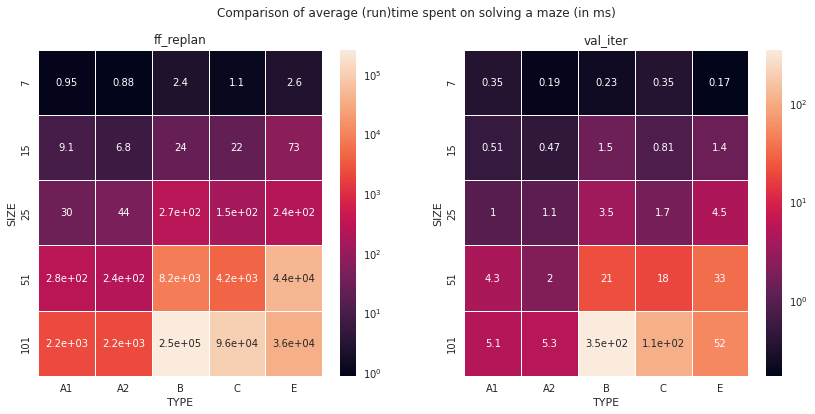

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
plt.style.use("seaborn")
    
plt.figure(figsize=[7*len(ALGOS),6])
plt.suptitle("Comparison of average (run)time spent on solving a maze (in ms)")
for k, a in enumerate(ALGOS):
    plt.subplot(1,len(ALGOS),k+1)
    time_mat = np.empty((5,5))
    for i, s in enumerate(SIZES):
        for j, t in enumerate(TYPES):
            time_mat[i,j] = times[a][s][t]/len(rewards[a][s][t])*1000
    
    heat_map = sns.heatmap(time_mat, linewidth=1, annot= True, norm=LogNorm(), xticklabels=TYPES, yticklabels=SIZES)
    plt.xlabel('TYPE')
    plt.ylabel('SIZE')
    plt.title(f"{a}")
plt.show()

NOTE: The color scale is **logarithmic** and **different** for both plots. 

This is intentional, as it helps the argument of showing an intrinsic complexity of the mazes. From this we can see, that the B and C types of mazes (walls are delays / empty space is delay) take the most time. Naturally, if we can walk of track every time (no walls) the FF-replan will need a lot of computation time. 

But still, we see a steeper increase in time demands for FF-replan, compared to Value Iteration even on the standard (A1, A2).

Mazes of type E, the special ones, are often also less constrained (more walkable space), posing a difficult task to FF-replan.

### Rewards
Now, lets turn to rewards. This is a more important comparison to make. Firstly let's show some boxplots on A-type and E-type mazes.

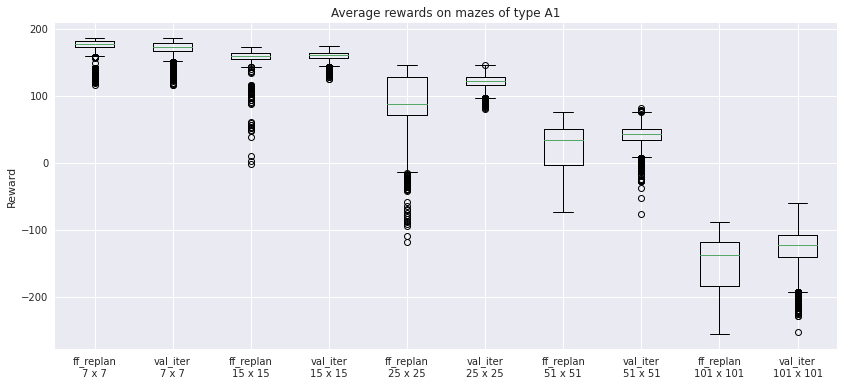

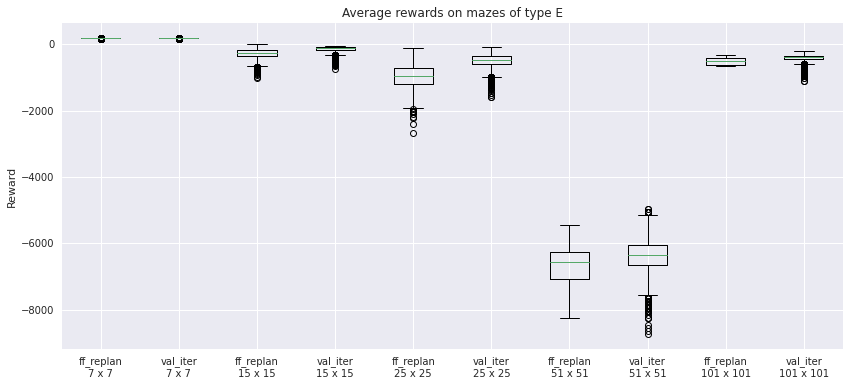

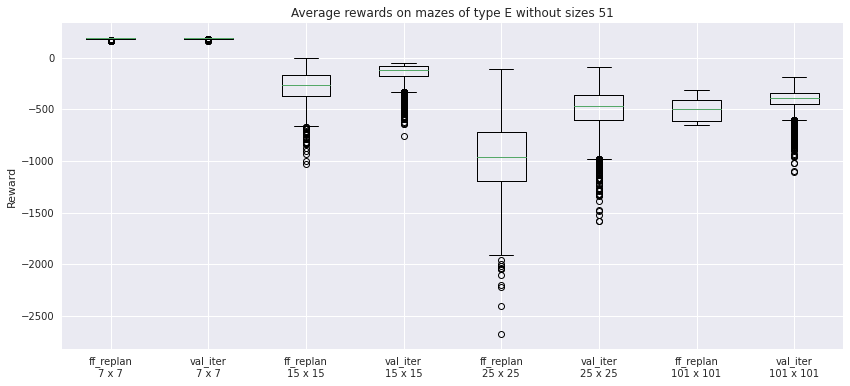

In [8]:
def show_boxplot_for_type(t, excluded_sizes=[]):
    plt.figure(figsize=[7*len(ALGOS),6])
    rews = []
    ticks = []
    for s in SIZES:
        if s not in excluded_sizes:
            for a in ALGOS:
                rews.append(np.array(rewards[a][s][t]))
                ticks.append(f"{a}\n{s} x {s}")

    plt.boxplot(rews)
    plt.xticks(range(1, len(rews)+1), ticks)
    # plt.xlabel('mazes and ')
    plt.ylabel('Reward')
    plt.title(f"Average rewards on mazes of type {t}" + (f" without sizes {', '.join(excluded_sizes)}" if len(excluded_sizes) > 0 else ""))
    plt.show()
    
show_boxplot_for_type("A1")
show_boxplot_for_type("E")
show_boxplot_for_type("E", excluded_sizes=["51"])

On the mazes of A type, we can clearly see, that with increasing complexity of the maze, Value Iteration starts to clearly outperform FF-replan. On the intricate (E) mazes, we first notice a particularly odd maze od size 51x51. It is a maze that has nothing but delay positions. Here, the VI policy and actions taken by FF-replan should be very similar (as in the 7x7 case, where the maze is empty). The difference might be a byproduct of lower number of iterations. If we exclude that maze, to see the other boxplots more clearly, a similar thing appears as in the case of A1 mazes.

The Value Iteration has higher means and lower variance. I would thus argue that the results clearly side the Value Iteration, as expected.

In [9]:
# print(Maze("dataset-assignment2/data/maze-51-E.txt"))

Let me show some numbers too. Firstly, let's look at on how many mazes is Value Iteration better than FF-replan and by how much.

In [10]:
diff_from = "val_iter"

print("Differences of average rewards compared to Value Iteration:")
print()
for a in ALGOS:
    if a != diff_from:
        print(a)
        print(" "*13, end="")
        for t in TYPES:
            print(t.ljust(8), end="")
        print()
        for s in SIZES:
            print(f"{s}x{s}:".ljust(8), end="")
            for t in TYPES:
                mean_diff = np.mean(rewards[diff_from][s][t]) - np.mean(rewards[a][s][t])
                print(f"{mean_diff:.2f}".rjust(8), end="")
            print()
        print()

Differences of average rewards compared to Value Iteration:

ff_replan
             A1      A2      B       C       E       
7x7:        0.80    1.47    2.90   34.02    0.66
15x15:      3.86    3.96  120.29  136.13  140.16
25x25:     32.75   11.65  146.98  216.19  490.13
51x51:     19.13    4.53  280.04  265.82  278.21
101x101:   29.25   34.84  551.33  725.39   95.55



We clearly see that in every variant, the Value iteration has the upper hand (though sometimes just marginally). The closest is in the already mentioned 7x7 - E maze, that is just empty. This difference might be based on luck, but I would argue it is caused by the way Value Iteration works with walls, whereas FF-replan does not take them into account.

In [11]:
# e = Engine(Maze("dataset-assignment2/data/maze-7-E.txt"))
# ValueIteration(e, gamma=0.99999, lim_residual=1e-10).show_policy(e)

# p, _, _ = simulate_sequence(e, FFReplan(e))
# path_map = [[None]*e.maze.w for _ in range(e.maze.h)]
# for i, (pos, direction) in enumerate(p):
#     path_map[pos.y][pos.x] = str(i%100) + str(direction)
# print(e.maze.to_str(path_map))

More relevant is however difference relative to the value achieved by FF-replan:

In [12]:
rel_to = "val_iter"

print("Relative diffferences of average rewards compared to Value Iteration:")
print()
for a in ALGOS:
    if a != rel_to:
        tot_coef = 0
        averages = {}
        print(a)
        print(" "*13, end="")
        for t in TYPES:
            averages[t] = 0
            print(t.ljust(8), end="")
        print("Average")
        for s in SIZES:
            average = 0
            print(f"{s}x{s}:".ljust(8), end="")
            for t in TYPES:
                # reverse and shift by 200, the upper bound, to make the numbers comparable
                mean_a = 200 - np.mean(rewards[a][s][t])
                mean_diff = mean_a - (200 - np.mean(rewards[diff_from][s][t]))
                mean_coef = mean_diff / mean_a
                print(f"{mean_coef:.3f}".rjust(8), end="")
                tot_coef += mean_coef
                averages[t] += mean_coef
                average += mean_coef
            print("  | ",f"{average/len(TYPES):.3f}".rjust(6), end="")
            print()
        print("-"*60)
        print("Average ", end="")
        for t in TYPES:
            print(f"{averages[t]/len(SIZES):.3f}".rjust(8), end="")
        print()
        print(f"In total, the average relative difference is {tot_coef/(len(TYPES)*len(SIZES)):.3f}")
        print()

Relative diffferences of average rewards compared to Value Iteration:

ff_replan
             A1      A2      B       C       E       Average
7x7:       0.028   0.059   0.020   0.050   0.047  |   0.041
15x15:     0.089   0.091   0.288   0.083   0.291  |   0.168
25x25:     0.295   0.121   0.268   0.076   0.417  |   0.236
51x51:     0.108   0.027   0.269   0.041   0.041  |   0.097
101x101:   0.082   0.095   0.184   0.057   0.136  |   0.111
------------------------------------------------------------
Average    0.120   0.079   0.206   0.061   0.186
In total, the average relative difference is 0.131



Here, as could be expected, on B mazes, that do not constrain movement FF-replan will be less likely to walk through "walls" that are here just delays. On C mazes, on the other hand, it is mostly about selecting the shortest path, so the difference is not really relevant. 

Another thing I looked into are the A1 mazes of size 25x25 and 51x51. These are mazes, where around the shortest deterministic path, there are some delay fields. But because FF-replan does not take them into account, it likely falls into them from time to time, which leads to the decrease in score. Value Iteration chooses a different, longer, but safe route. The bigger the maze is, the lower the relative difference, because all total rewards are getting lower, so one -50 makes lower and lower difference.

In [13]:
# print(Maze("dataset-assignment2/data/maze-25-A1.txt"))
# print(Maze("dataset-assignment2/data/maze-51-A1.txt"))

## Conclusion
All in all, the Value Iteration beats FF-replan in every aspect I looked into. This would not be the case for too big state spaces that would not fit to memory, or maybe if we would not know the stochasticity of the environment.

To be honest, I was surprised, that the FF-replan does not yield that much worse results relatively compared to VI, given its simplicity.

NOTE: I would still like to implement MCTS, however I could not manage that in time, thus I would like you to evaluate my work and give me feedback on what is problematic, so that I can look into it and how many points would this give me. (I am going for the full 20, clearly :D)

Thank you. 